# Modelos de clasificacion


5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity


### Luis F. Lopez Arnaud.
### Francisco Gonzalez Lazalde



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, LSTM, Bidirectional, ConvLSTM2D, MaxPooling3D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('Epileptic Seizure Recognition.csv')
df

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [3]:
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

[]

In [4]:
value_counts = df['y'].value_counts()
print("Conteo de valores únicos en 'y':\n")
print(value_counts.to_markdown(tablefmt="grid"))

Conteo de valores únicos en 'y':

+-----+---------+
|   y |   count |
+=====+=========+
|   4 |    2300 |
+-----+---------+
|   1 |    2300 |
+-----+---------+
|   5 |    2300 |
+-----+---------+
|   2 |    2300 |
+-----+---------+
|   3 |    2300 |
+-----+---------+


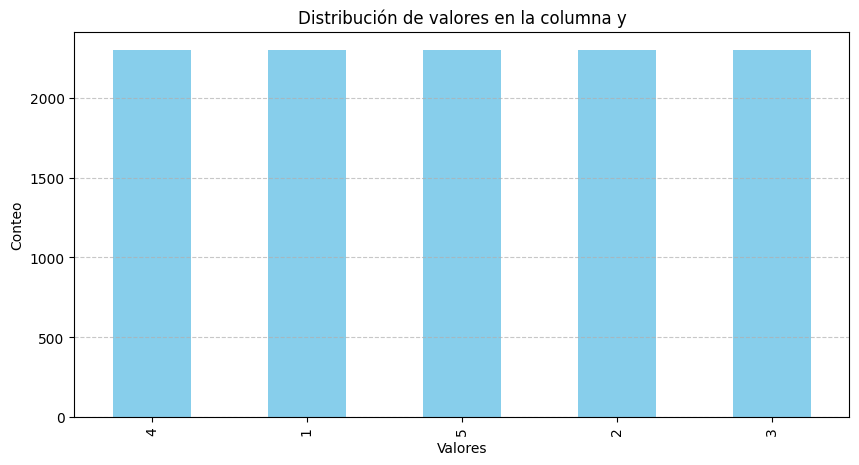

In [5]:
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de valores en la columna y')
plt.xlabel('Valores')
plt.ylabel('Conteo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
df = df.drop(df.columns[0], axis=1)
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,1
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,121,135,148,143,116,86,68,59,55,3


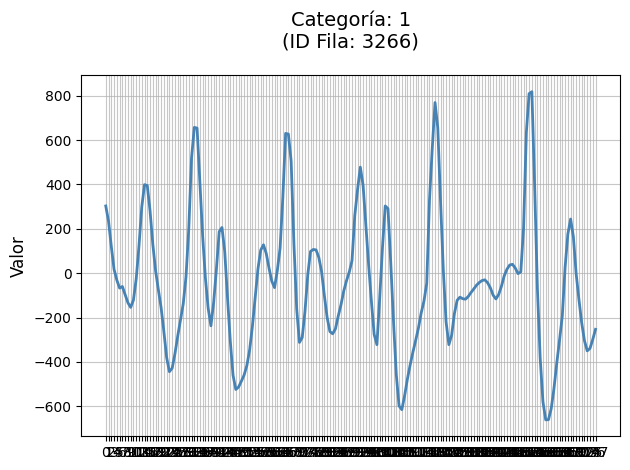

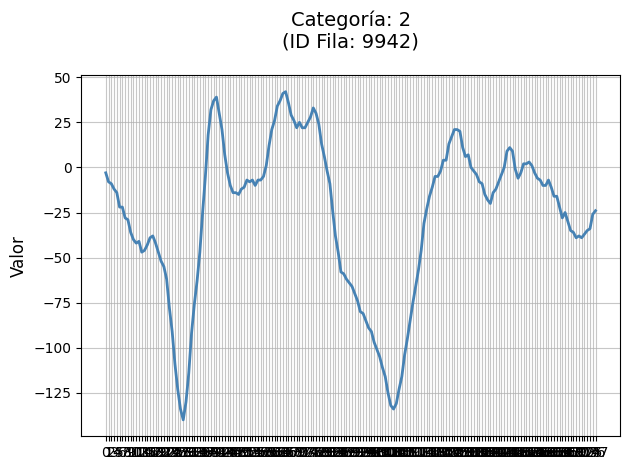

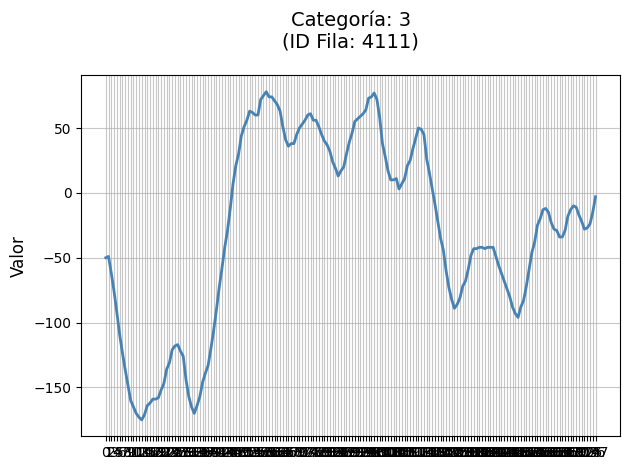

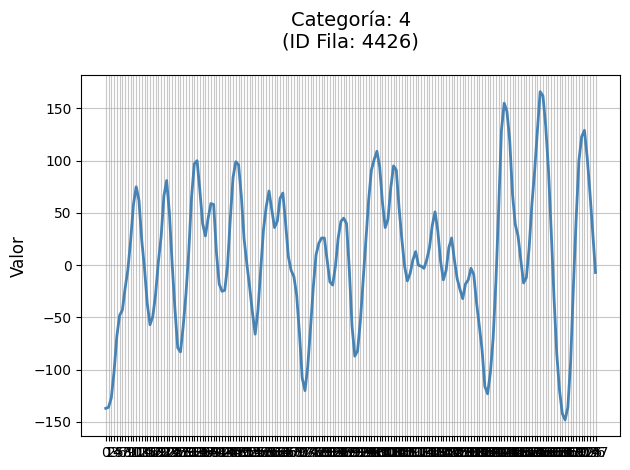

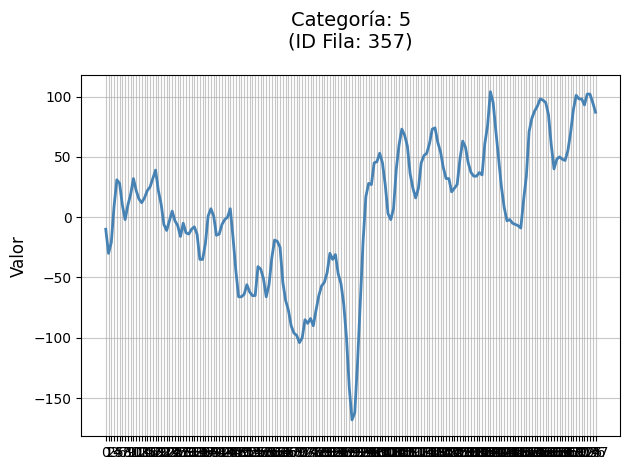

In [9]:
categorias = sorted(df['y'].unique())
for categoria in categorias:
    subset = df[df['y'] == categoria]
    fila_aleatoria = subset.sample(1).iloc[0]
    fig, ax = plt.subplots()
    ax.plot(fila_aleatoria.drop('y').values,
            color='steelblue',
            linestyle='-',
            linewidth=2,
            markersize=8)

    ax.set_title(f'Categoría: {categoria}\n(ID Fila: {fila_aleatoria.name})',
                 fontsize=14, pad=20)
    ax.set_ylabel('Valor', fontsize=12)
    ax.grid(True, alpha=0.7)
    ax.set_xticks(range(len(fila_aleatoria)-1))
    plt.tight_layout()
    plt.show()

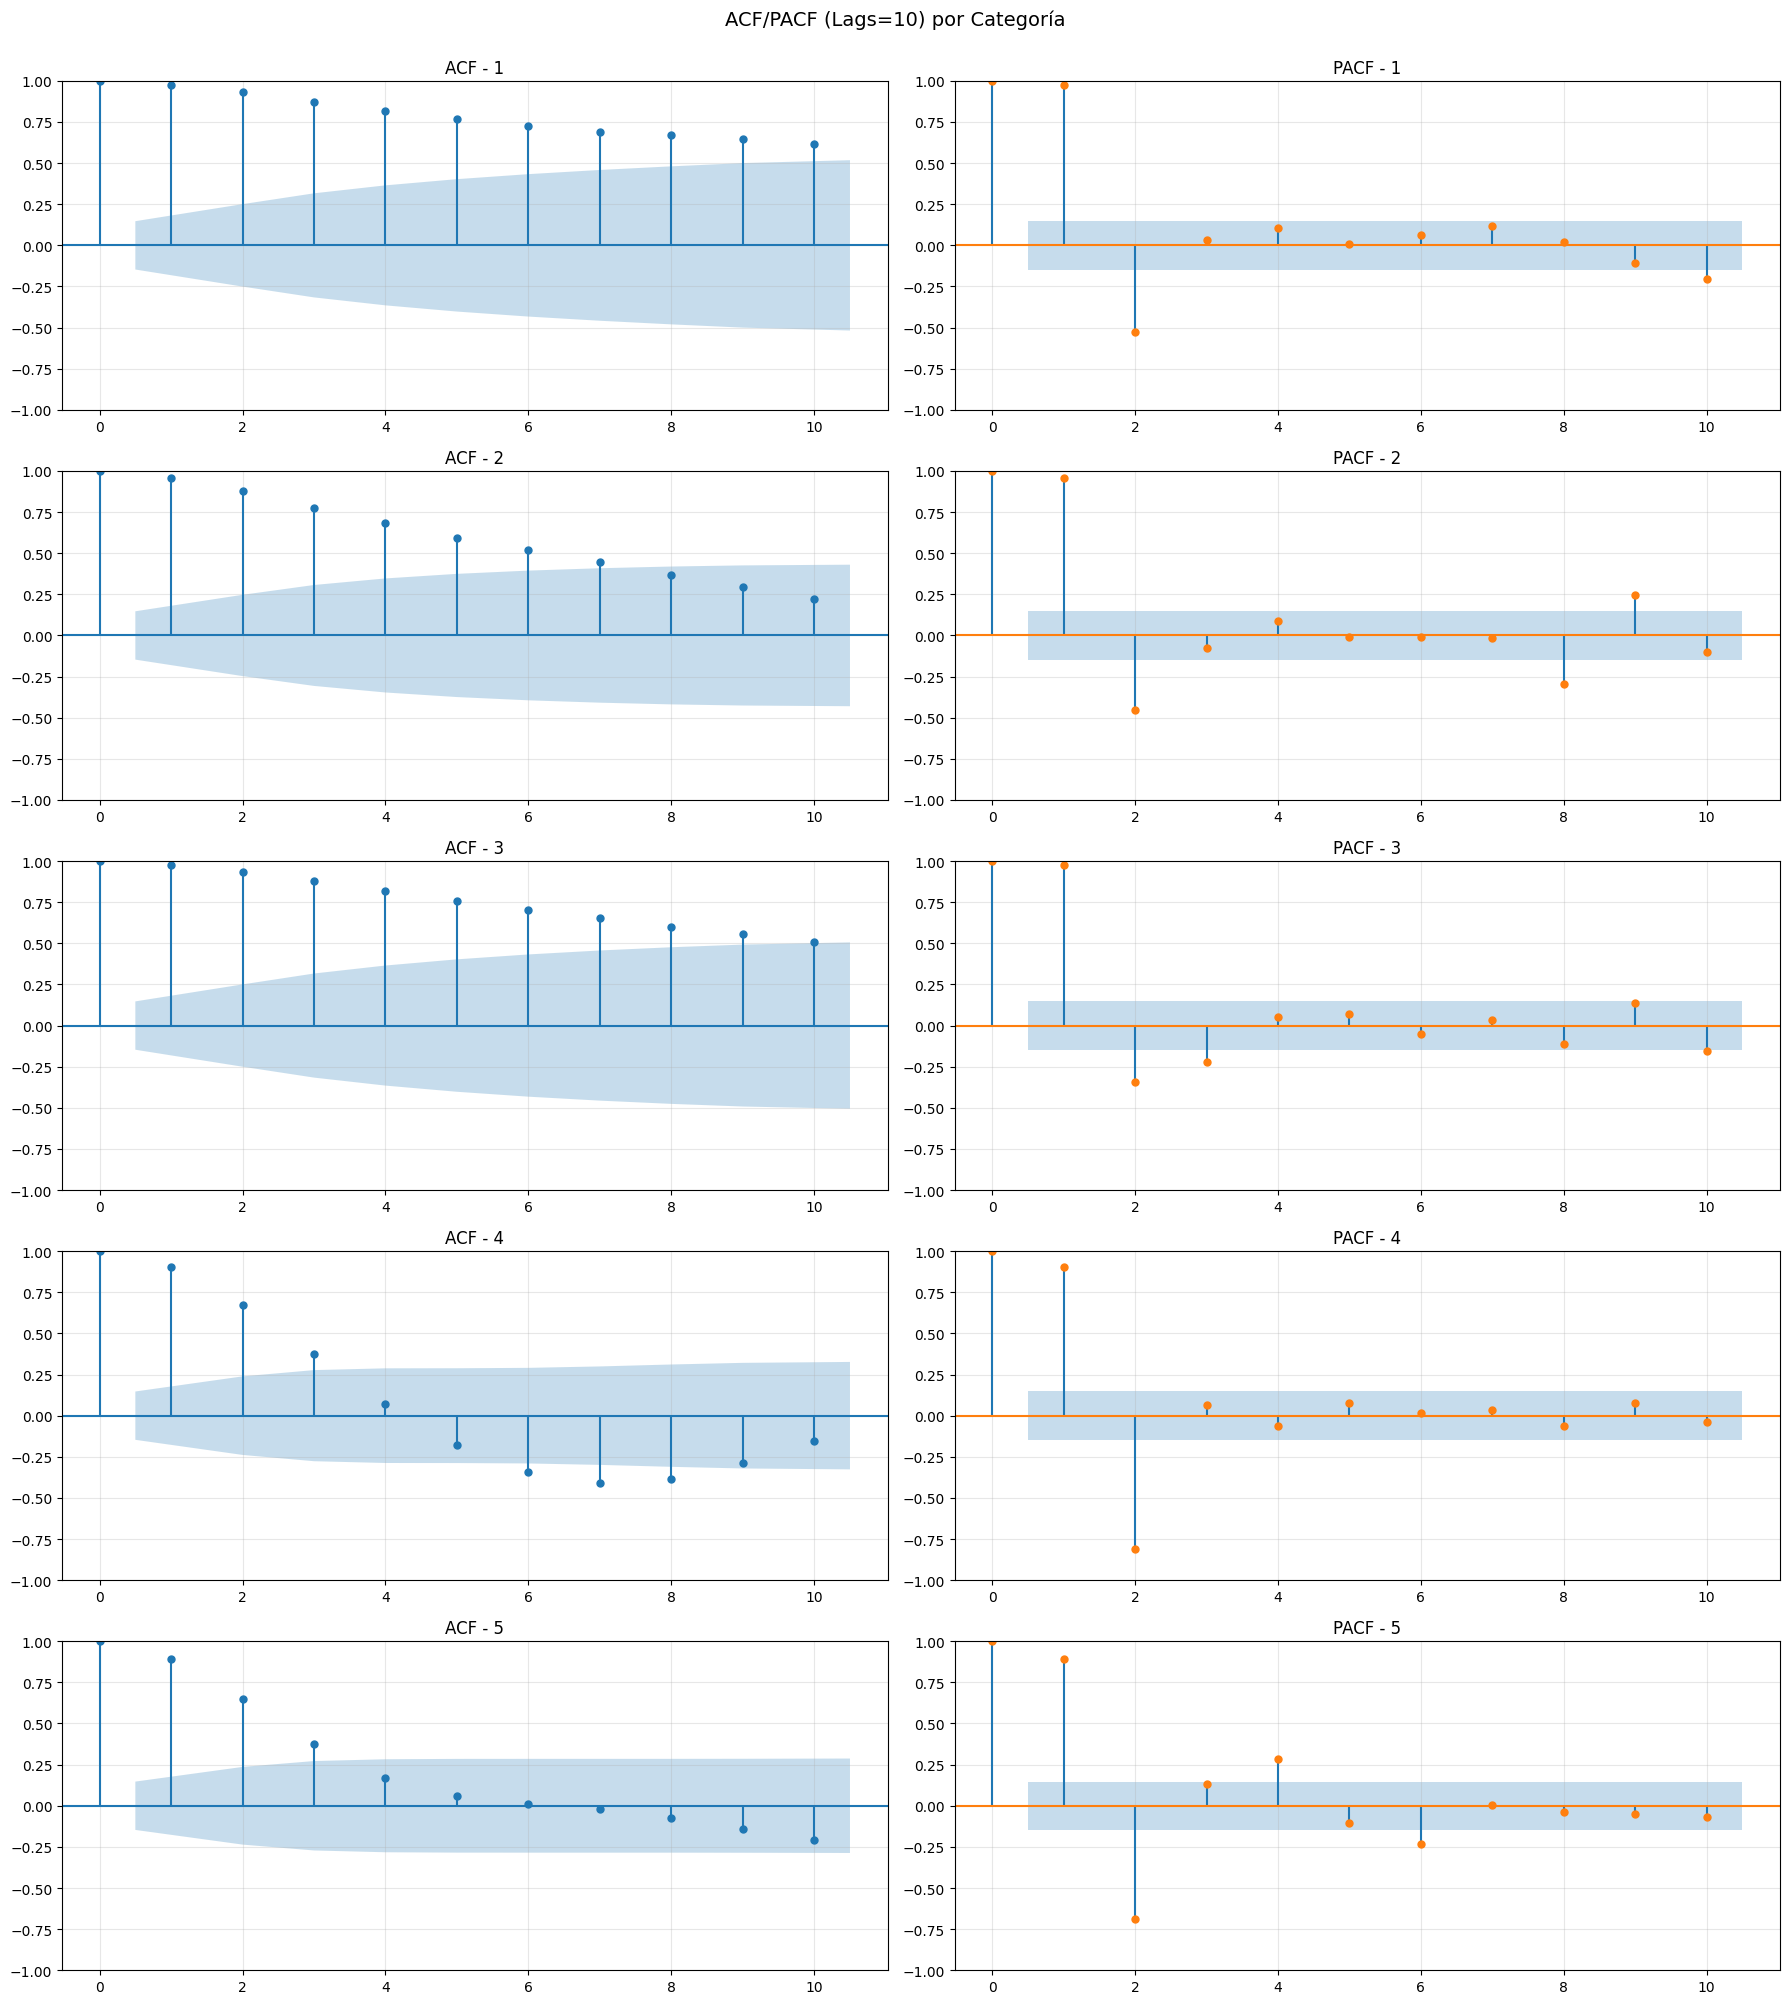

In [11]:
n_categorias = len(df['y'].unique())
filas_seleccionadas = []
categorias = sorted(df['y'].unique())
for categoria in categorias:
    subset = df[df['y'] == categoria]
    filas_seleccionadas.append((categoria, subset.sample(1).iloc[0]))
fig, axes = plt.subplots(n_categorias, 2, figsize=(18, 4*n_categorias))
for i, (categoria, fila) in enumerate(filas_seleccionadas):
    serie = fila.drop('y').values
    lags = min(10, len(serie)-1)
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_acf(serie, lags=lags, ax=axes[i,0],
             title=f'ACF - {categoria}')
    plot_pacf(serie, lags=lags, ax=axes[i,1],
             title=f'PACF - {categoria}')

    for j in [0,1]:
        axes[i,j].grid(True, alpha=0.3)
        axes[i,j].set_xlabel('')
plt.tight_layout()
plt.show()

In [69]:
def normalize_row(row):
    row_min = row.min()
    row_max = row.max()
    if row_min == row_max:
        return row
    return 2 * ((row - row_min) / (row_max - row_min)) - 1

df_normalized = df.drop('y', axis=1).apply(normalize_row, axis=1)
df_normalized['y'] = df['y']

In [70]:
df1= df_normalized.copy()

In [71]:
from sklearn.model_selection import train_test_split
def stratified_time_series_split(df, target_col='y', test_size=0.15, val_size=0.15, random_state=42):
    train_df, temp_df = train_test_split(
        df,
        test_size=(test_size + val_size),
        stratify=df[target_col],
        random_state=random_state
    )
    test_df, val_df = train_test_split(
        temp_df,
        test_size=val_size/(test_size + val_size),
        stratify=temp_df[target_col],
        random_state=random_state
    )

    return train_df, test_df, val_df
train_data, test_data, val_data = stratified_time_series_split(df1)

In [72]:
print(f"Distribución original:\n{df1['y'].value_counts(normalize=True)}\n")
print(f"Train set ({len(train_data)/len(df1):.1%}):\n{train_data['y'].value_counts(normalize=True)}\n")
print(f"Test set ({len(test_data)/len(df1):.1%}):\n{test_data['y'].value_counts(normalize=True)}\n")
print(f"Validation set ({len(val_data)/len(df1):.1%}):\n{val_data['y'].value_counts(normalize=True)}")


Distribución original:
y
4    0.2
1    0.2
5    0.2
2    0.2
3    0.2
Name: proportion, dtype: float64

Train set (70.0%):
y
4    0.2
2    0.2
1    0.2
5    0.2
3    0.2
Name: proportion, dtype: float64

Test set (15.0%):
y
4    0.2
3    0.2
2    0.2
5    0.2
1    0.2
Name: proportion, dtype: float64

Validation set (15.0%):
y
3    0.2
5    0.2
1    0.2
2    0.2
4    0.2
Name: proportion, dtype: float64


In [73]:
X = df1.drop('y', axis=1)
y = df1['y']
train_idx, temp_idx = train_test_split(
    np.arange(len(df1)),
    test_size=0.3,
    stratify=y,
    random_state=42
)

test_idx, val_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=y.iloc[temp_idx],
    random_state=42
)

In [74]:
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [21]:
y_train = y_train - 1
y_test = y_test - 1
y_val = y_val - 1
model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    print(f"\n{'='*40}")
    print(f"Métricas para {set_name}")
    print('='*40)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=4))

    metrics = []
    classes = model.classes_
    for i, class_name in enumerate(classes):
        precision, recall, f1, _ = precision_recall_fscore_support(
            y == class_name,
            y_pred == class_name,
            average='binary'
        )
        metrics.append({
            'Clase': class_name,
            'Precisión': round(precision, 4),
            'Recall': round(recall, 4),
            'F1-Score': round(f1, 4),
            'Muestra': (y == class_name).sum()
        })

    return pd.DataFrame(metrics)

In [23]:
test_metrics = evaluate_model(model, X_test, y_test, "test")
val_metrics = evaluate_model(model, X_val, y_val, "val")


Métricas para CONJUNTO DE PRUEBA

Classification Report:
              precision    recall  f1-score   support

           0     0.7534    0.6377    0.6907       345
           1     0.5524    0.5043    0.5273       345
           2     0.5570    0.6087    0.5817       345
           3     0.6747    0.7333    0.7028       345
           4     0.5109    0.5420    0.5260       345

    accuracy                         0.6052      1725
   macro avg     0.6097    0.6052    0.6057      1725
weighted avg     0.6097    0.6052    0.6057      1725


Métricas para CONJUNTO DE VALIDACIÓN

Classification Report:
              precision    recall  f1-score   support

           0     0.7299    0.6580    0.6921       345
           1     0.5666    0.5304    0.5479       345
           2     0.5385    0.5478    0.5431       345
           3     0.6619    0.6696    0.6657       345
           4     0.5115    0.5797    0.5435       345

    accuracy                         0.5971      1725
   macro av

In [30]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=15,
    random_state=42,
    verbose=True
)
history = mlp_model.fit(X_train, y_train)


Iteration 1, loss = 1.47050813
Validation score: 0.458609
Iteration 2, loss = 1.15278578
Validation score: 0.522351
Iteration 3, loss = 0.98311903
Validation score: 0.562086
Iteration 4, loss = 0.89894313
Validation score: 0.572020
Iteration 5, loss = 0.83970492
Validation score: 0.572020
Iteration 6, loss = 0.80287155
Validation score: 0.567881
Iteration 7, loss = 0.75698543
Validation score: 0.572848
Iteration 8, loss = 0.73490568
Validation score: 0.572848
Iteration 9, loss = 0.69913131
Validation score: 0.568709
Iteration 10, loss = 0.67282873
Validation score: 0.588576
Iteration 11, loss = 0.64479905
Validation score: 0.586093
Iteration 12, loss = 0.62337885
Validation score: 0.593543
Iteration 13, loss = 0.59359361
Validation score: 0.586921
Iteration 14, loss = 0.57682710
Validation score: 0.591887
Iteration 15, loss = 0.55731721
Validation score: 0.586093
Iteration 16, loss = 0.53514644
Validation score: 0.590232
Iteration 17, loss = 0.51187214
Validation score: 0.592715
Iterat

In [ ]:
def evaluate_mlp(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    print(f"\n{'='*40}")
    print(f"Evaluación MLP - {set_name}")
    print('='*40)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=4))

    metrics = []
    classes = model.classes_
    for i, class_name in enumerate(classes):
        precision, recall, f1, _ = precision_recall_fscore_support(
            y == class_name,
            y_pred == class_name,
            average='binary',
            zero_division=0
        )
        metrics.append({
            'Clase': class_name,
            'Precisión': round(precision, 4),
            'Recall': round(recall, 4),
            'F1-Score': round(f1, 4),
            'Muestras': (y == class_name).sum()
        })

    return pd.DataFrame(metrics)

In [36]:
print(f"Iteraciones finales: {mlp_model.n_iter_}")
print(f"Pérdida final: {mlp_model.loss_:.4f}")

test_metrics = evaluate_mlp(mlp_model, X_test, y_test, "test")
val_metrics = evaluate_mlp(mlp_model, X_val, y_val, "val")

Iteraciones finales: 28
Pérdida final: 0.3307

Evaluación MLP - test

Classification Report:
              precision    recall  f1-score   support

           0     0.6960    0.6638    0.6795       345
           1     0.5212    0.5333    0.5272       345
           2     0.5510    0.5478    0.5494       345
           3     0.7500    0.6348    0.6876       345
           4     0.5270    0.6232    0.5710       345

    accuracy                         0.6006      1725
   macro avg     0.6091    0.6006    0.6030      1725
weighted avg     0.6091    0.6006    0.6030      1725


Evaluación MLP - val

Classification Report:
              precision    recall  f1-score   support

           0     0.6754    0.6696    0.6725       345
           1     0.5367    0.5304    0.5335       345
           2     0.5426    0.5536    0.5481       345
           3     0.7395    0.6667    0.7012       345
           4     0.5383    0.5913    0.5635       345

    accuracy                         0.6023   

In [37]:
for name, X, y in [('Entrenamiento', X_train, y_train),
                   ('Prueba', X_test, y_test),
                   ('Validación', X_val, y_val)]:
    acc = mlp_model.score(X, y)
    print(f"\nExactitud {name}: {acc:.4f}")


Exactitud Entrenamiento: 0.7527

Exactitud Prueba: 0.6006

Exactitud Validación: 0.6023


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,0.631373,0.847059,1.000000,0.976471,0.854902,0.592157,0.317647,0.066667,-0.027451,-0.047059,...,0.035294,0.043137,-0.019608,-0.200000,-0.301961,-0.396078,-0.352941,-0.223529,-0.098039,4
1,0.886048,0.882459,0.859130,0.836698,0.826828,0.822342,0.815164,0.783760,0.758636,0.747869,...,0.686855,0.674293,0.670704,0.676088,0.680574,0.679677,0.677882,0.668013,0.655451,1
2,-0.087379,-0.155340,-0.233010,-0.135922,-0.087379,-0.126214,-0.330097,-0.485437,-0.601942,-0.689320,...,0.776699,0.844660,0.689320,0.407767,0.106796,-0.067961,-0.116505,-0.116505,-0.126214,5
3,-1.000000,-0.903614,-0.783133,-0.686747,-0.614458,-0.759036,-0.927711,-0.879518,-0.566265,-0.373494,...,-0.445783,-0.421687,-0.397590,-0.325301,-0.518072,-0.325301,-0.204819,-0.132530,-0.036145,5
4,0.038674,-0.580110,-0.944751,-0.988950,-0.723757,-0.392265,-0.038674,0.138122,-0.093923,-0.513812,...,0.182320,0.160221,0.005525,-0.215470,-0.314917,-0.580110,-0.779006,-0.845304,-0.668508,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-0.250000,-0.250000,-0.263158,-0.302632,-0.434211,-0.513158,-0.552632,-0.513158,-0.552632,-0.605263,...,0.236842,0.250000,0.197368,0.105263,0.026316,-0.197368,-0.447368,-0.578947,-0.592105,2
11496,-0.206054,-0.122235,-0.031432,0.082654,0.231665,0.394645,0.476135,0.462165,0.352736,0.220023,...,-0.247963,-0.173458,-0.112922,-0.064028,-0.033760,0.015134,0.082654,0.175786,0.299185,1
11497,-0.014218,-0.090047,-0.270142,-0.298578,-0.052133,0.099526,0.109005,-0.232227,-0.109005,-0.014218,...,-0.763033,-0.601896,-0.725118,-0.734597,-0.781991,-0.431280,-0.165877,-0.156398,-0.222749,5
11498,-0.232787,-0.134426,-0.029508,-0.049180,0.016393,0.108197,0.075410,0.154098,0.173770,0.219672,...,0.822951,0.914754,1.000000,0.967213,0.790164,0.593443,0.475410,0.416393,0.390164,3


In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D # Import these
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam

In [140]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [167]:
def crear_modelo_cnn(INPUT_SHAPE, NUM_CLASES):
    model = Sequential([
        Conv1D(64, 5, activation='relu', padding='same',
               input_shape=INPUT_SHAPE, kernel_initializer='he_normal'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu', padding='same',
               kernel_regularizer=l2(0.0001)),
        MaxPooling1D(2),
        Dropout(0.4),

        Conv1D(128, 3, activation='relu', padding='same',
               kernel_initializer='he_normal'),
        BatchNormalization(),

        Flatten(),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        Dense(NUM_CLASES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [161]:
def crear_modelo_lstm(INPUT_SHAPE, NUM_CLASES):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True,
                         kernel_regularizer=l1_l2(0.0001, 0.0001),
                         recurrent_initializer='orthogonal'),
                    input_shape=INPUT_SHAPE),
        BatchNormalization(),
        Bidirectional(LSTM(128, return_sequences=True,
                         kernel_regularizer=l1_l2(0.0001, 0.0001))),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, return_sequences=False,
           kernel_regularizer=l1_l2(0.0001, 0.0001)),

        Dense(128, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=l1_l2(0.001, 0.001)),
        BatchNormalization(),

        Dense(NUM_CLASES, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001,
                   clipvalue=0.5,
                   decay=1e-4)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'sparse_categorical_accuracy'])

    return model

In [162]:
def crear_modelo_cnn_lstm(INPUT_SHAPE, NUM_CLASES):
    model = Sequential([
        Conv1D(64, 5, activation='relu', padding='same',
              input_shape=INPUT_SHAPE, kernel_initializer='he_normal'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu', padding='same',
              kernel_regularizer=l2(0.0001)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same',
              kernel_regularizer=l2(0.0001)),
        Dropout(0.4),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(NUM_CLASES, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001,
                   clipvalue=0.5,
                   decay=1e-4)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'sparse_categorical_accuracy'])

    return model

In [ ]:
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SHAPE = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
NUM_CLASES = len(np.unique(np.concatenate((y_train, y_val, y_test))))

In [168]:
modelo_cnn = crear_modelo_cnn(INPUT_SHAPE, NUM_CLASES)
modelo_cnn.summary()
historia_cnn = modelo_cnn.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_31 (Conv1D)              │ (None, 178, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 178, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 178, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 89, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 89, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 89, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 89, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11392)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     1,458,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,534,597 (5.85 MB)

 Trainable params: 1,533,957 (5.85 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.0030 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: na

In [169]:
modelo_lstm = crear_modelo_lstm(INPUT_SHAPE, NUM_CLASES)
modelo_lstm.summary()
historia_lstm = modelo_lstm.fit(
    X_train_reshaped, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 178, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 178, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 178, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 178, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 178, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,061 (2.37 MB)

 Trainable params: 619,781 (2.36 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2040 - loss: nan - sparse_categorical_accuracy: 0.2040 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2047 - loss: nan - sparse_categorical_accuracy: 0.2047 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2028 - loss: nan - sparse_categorical_accuracy: 0.2028 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1986 - loss: nan - sparse_categorical_accuracy: 0.1986 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1986 - loss: nan - sparse_categorical_accuracy: 0.1986 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_cate

In [170]:
modelo_cnn_lstm = crear_modelo_cnn_lstm(INPUT_SHAPE, NUM_CLASES)
modelo_cnn_lstm.summary()
historia_cnn_lstm = modelo_cnn_lstm.fit(
    X_train_reshaped, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)              │ (None, 178, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 178, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 178, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 89, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 89, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 89, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,621 (748.52 KB)

 Trainable params: 190,981 (746.02 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1918 - loss: nan - sparse_categorical_accuracy: 0.1918 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2095 - loss: nan - sparse_categorical_accuracy: 0.2095 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1964 - loss: nan - sparse_categorical_accuracy: 0.1964 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1974 - loss: nan - sparse_categorical_accuracy: 0.1974 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categorical_accuracy: 0.2000
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2007 - loss: nan - sparse_categorical_accuracy: 0.2007 - val_accuracy: 0.2000 - val_loss: nan - val_sparse_categoric

In [171]:
modelos = {
    "CNN": modelo_cnn,
    "LSTM": modelo_lstm,
    "CNN-LSTM": modelo_cnn_lstm
}

target_names = [f'Clase {i}' for i in range(NUM_CLASES)]

In [172]:
for nombre_modelo, modelo_entrenado in modelos.items():
    y_pred_prob = modelo_entrenado.predict(X_test)
    y_pred_clases = np.argmax(y_pred_prob, axis=1)
    reporte = classification_report(y_test, y_pred_clases, target_names=target_names, zero_division=0)
    print(reporte)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00       345
     Clase 1       0.00      0.00      0.00       345
     Clase 2       0.20      1.00      0.33       345
     Clase 3       0.00      0.00      0.00       345
     Clase 4       0.00      0.00      0.00       345

    accuracy                           0.20      1725
   macro avg       0.04      0.20      0.07      1725
weighted avg       0.04      0.20      0.07      1725

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00       345
     Clase 1       0.00      0.00      0.00       345
     Clase 2       0.20      1.00      0.33       345
     Clase 3       0.00      0.00      0.00       345
     Clase 4       0.00      0.00      0.00       345

    accuracy                           0.20      1725
   macro avg       0.04      0.20      0.07      172